Renumbering residues of protein IDs specified in renumbering_dict.

Processed data was written into a csv file 'HDX processed data.csv'

Maximal difference in D uptake between protein states in the data is 3.16.

Before plotting, removed 4 rows from D uptake difference table that are completely empty. This happens when
some peptides are present in only one of the protein states.
You may wish to inspect output csv file to make sure processed data looks reasonable.

Before plotting, removed 2 columns from D uptake difference table that are completely empty. This happens when
some time points are present in only one of the protein states.
You may wish to inspect output csv file to make sure processed data looks reasonable.



C:\Users\kentv\AppData\Local\Temp\ipykernel_17612\1081489305.py:578: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data_avg=data_avg.stack('Exposure').unstack(level=['State','Exposure'])


Set 1038 D uptake differences with larger than 5.00e-02 p-values to 0 before plotting the data.



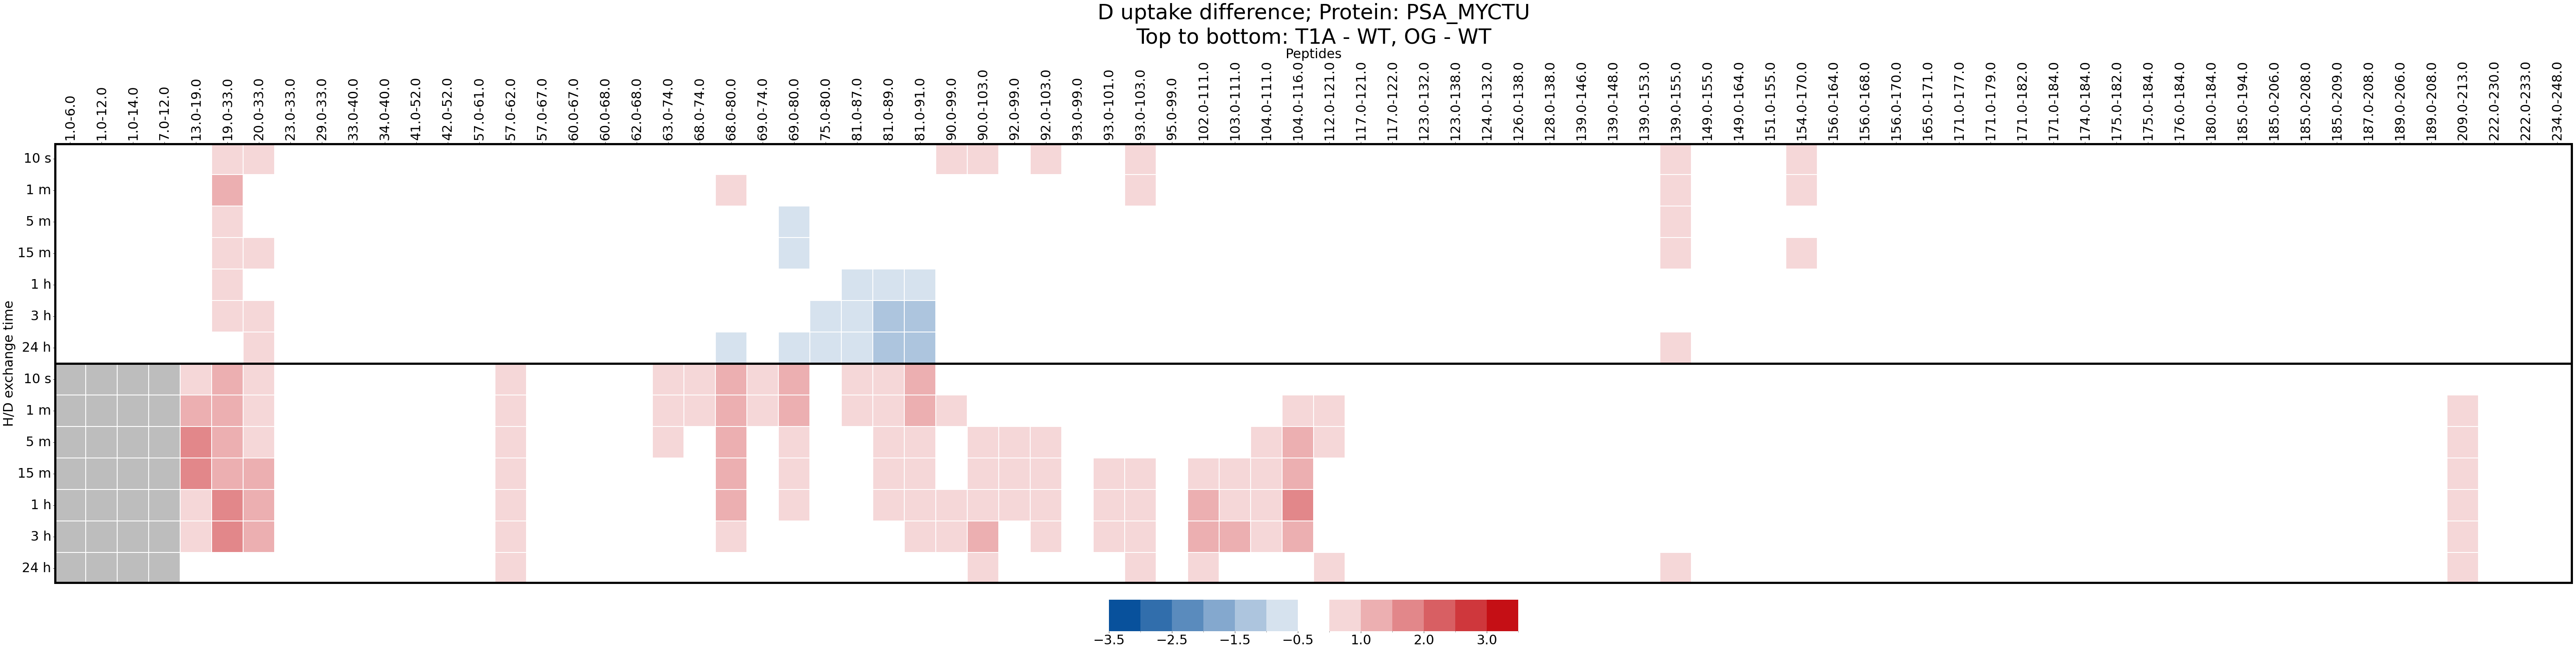

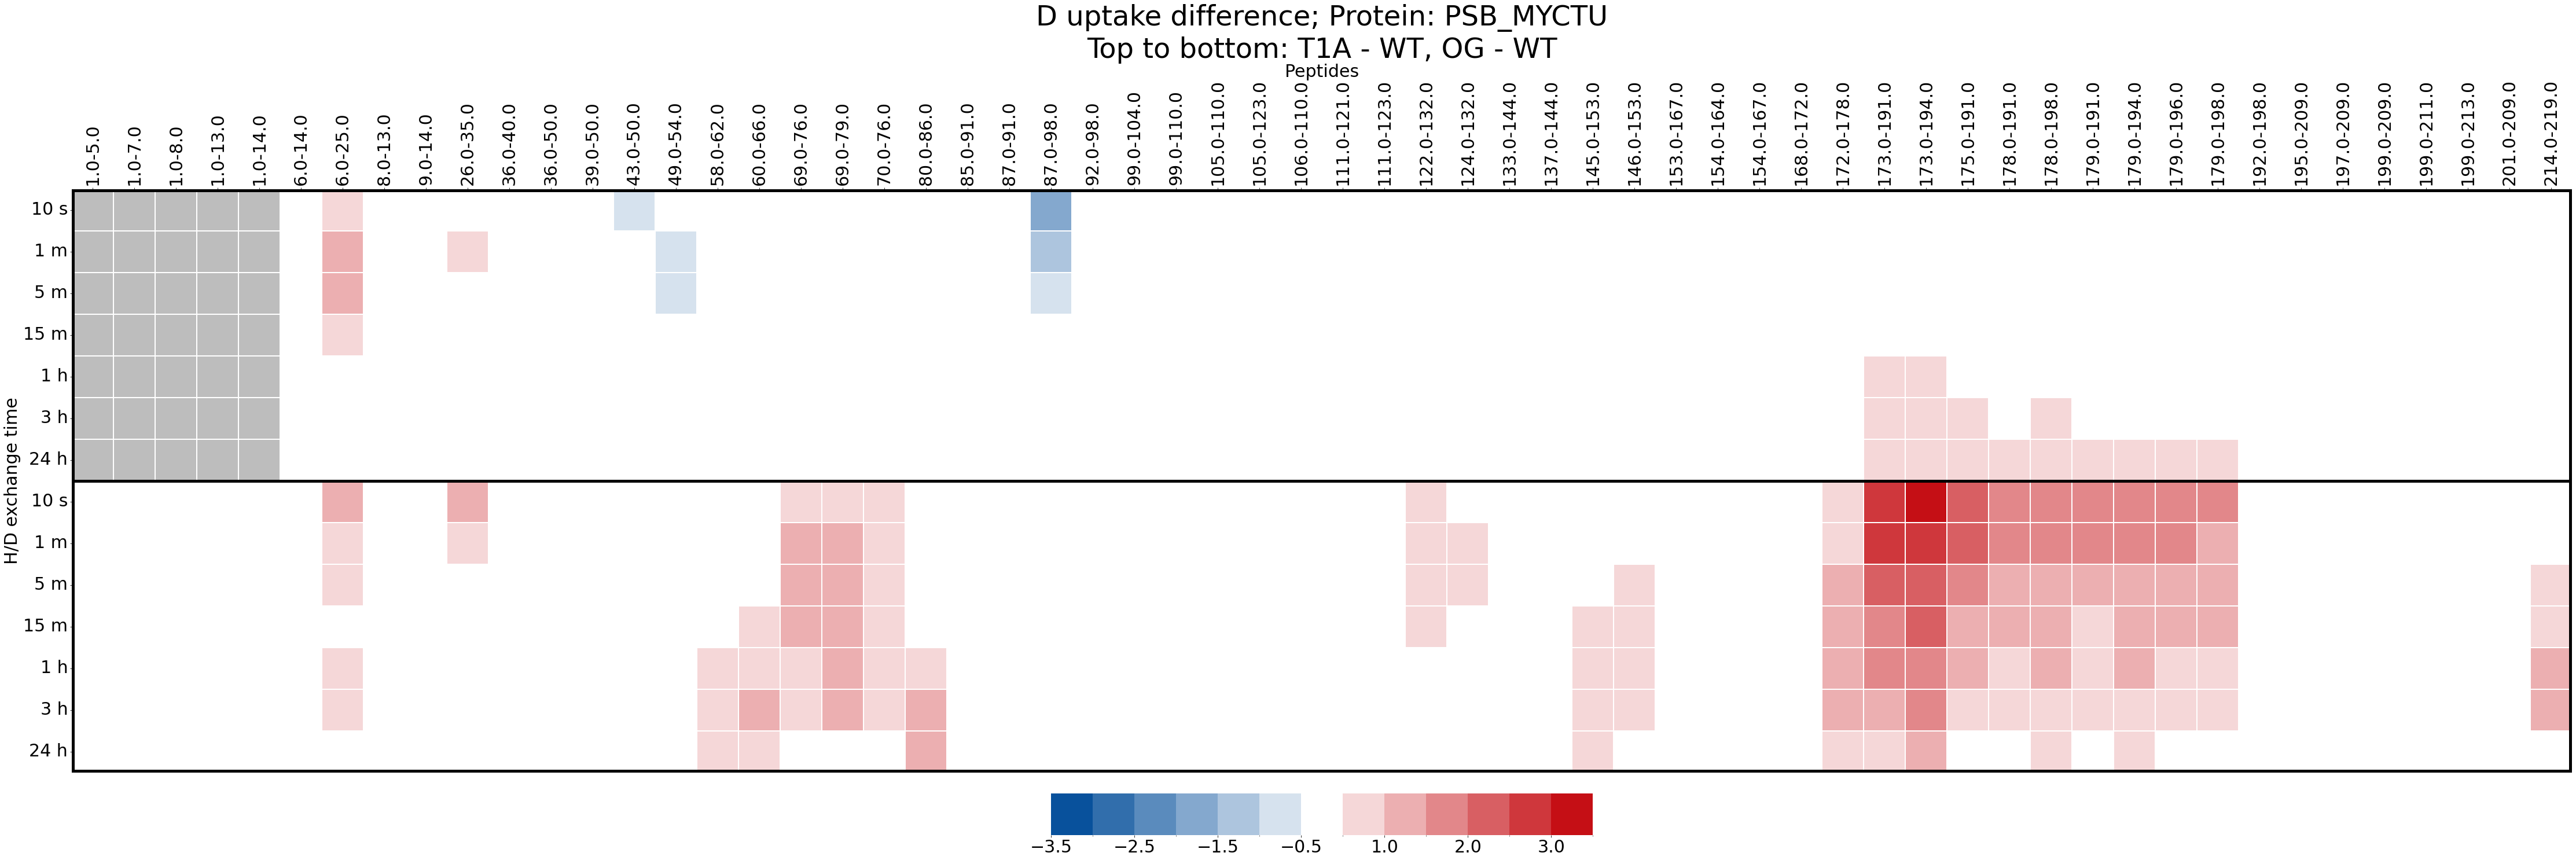

['#08519c', '#316eac', '#5a8bbd', '#84a8ce', '#adc5de', '#d6e2ee', '#ffffff', '#f5d7d8', '#ecafb1', '#e2878a', '#d85f63', '#cf373c', '#c50f15']
0x08519c
0x08519c
0x316eac
0x5a8bbd
0x84a8ce
0xadc5de
0xd6e2ee
0xffffff
0xf5d7d8
0xecafb1
0xe2878a
0xd85f63
0xcf373c
0xc50f15
0xc50f15


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import seaborn as sns
import time
import itertools
from pathlib import Path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import ttest_ind_from_stats

pd.options.display.width = 200

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# This used to work in older versions of IPython:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

###########################################################################################################################
#
# Constants and default values. Do not change this section.
# All of these variables can be set to desired values in the next section.

# proton mass
mp = 1.00727647

output_csv_file  = 'HDX processed data.csv'
output_pdf_file  = 'HDX heatmap.pdf'

output_bitmap = 1
output_bitmap_name = 'HDX heatmap'
output_bitmap_dpi = 100
output_bitmap_format = 'jpg'

renumbering_dict = {}
mut_id_dict = {}
mutation_dict = {}
mutation_msg = 1

drop_times = []
drop_pept  = []
drop_prot = []

p_threshold = 0.05
Dd_threshold = 0.5       # Delta D uptake threshold for the vertical line in scatter plot
significant_only = 1
scatter_plot = 0
scatter_dir = 'scatter_plots'

state1_list = []
state2_list = []
    
custom_bounds = []
custom_colors = []
    
max_range = 0
num_shades = 5

c1 = '#08519c' #blue 
c2 = 'white'   #white
c3 = '#c50f15' #red
c_missing = '#bdbdbd' # gray;

font_size = 36
font_size_title = 48

split_outp_by_prot = ''
split_outp_chunks = 0
split_outp_by_row = []

plot_h = 1
plot_v = 0
plot_stacked  = 0
plot_separate = 1

pymol_print = 1
pymol_dir = 'pymol_macros'
obj_id = ''
seg_id = ''
chain_id = ''
chain_dict = {}

#
###########################################################################################################################



###########################################################################################################################
#
# User-configurable variables

# Input and output file names:

input_csv_file   = r'C:\DynamX projects\14.08.23 OG w Ixazomib cluster data.csv'
input_csv_file   = r'State_raw.csv'
input_csv_file   = r'14.08.23 OG w Ixazomib cluster data.csv'
input_csv_file   = "C:\\Users\\kentv\\Downloads\\example HDX Data.csv"

output_csv_file  = r'HDX processed data.csv'
output_pdf_file  = r'HDX heatmap.pdf'

# File name, format, and resolution for a bitmap image output of heatmap plots.
# By default the script saves all plots into one combined pdf and individual bitmap files. Set output_bitmap = 0 if saved bitmaps are not needed.
# Plot files have names in the following style: name_x_N.format
# where x is either 'h' or 'v' and N is an integer starting at 0 and automatically incremented for each plot.
# Format must be one of the formats that matplotlib.pyplot.savefig() understands, e.g. 'png', 'jpg', 'tiff';
# (format can also be a vector graphics format such as 'pdf' or 'svg')

output_bitmap = 1
output_bitmap_name = 'HDX heatmap'
output_bitmap_dpi = 100
output_bitmap_format = 'jpg'

# --------------------------------------------------------------------------------------------------------

# Optional.
# When protein sequence used to analyze data in DynamX contains a propeptide, residue numbering in DynamX output
# will include that propeptide. Sometimes it is desirable to renumber residues to correspond to a mature,
# processed protein sequence. A variable below allows to do so in this script.
# If renumbering is desired, provide a dictionary indicating how much to subtract from residue numbers in which protein ID.
# Dict keys are protein IDs, dict values are subtrahends. See example below.
# Protein ID must be a string exactly as it appears in 'Protein' column of DynamX csv output file.
# If no renumberig is required this variable should be left commented out.

renumbering_dict = {'PSB_MYCTU' : 57,
                    'PSB_T1A'   : 57}

# --------------------------------------------------------------------------------------------------------

# Optional: dealing with mutant peptides in the data.

# If DynamX is used to analyze data from a mutant protein, there are several changes
# in data entries compared to the wt protein:
# 1) peptides containing mutated residues have different sequence;
# 2) protein IDs assigned to these peptides are different from the wt protein;
# 3) protein 'State' assigned to mutant protein data is different from the wt.
# If we want to plot D uptake difference between mutated peptide and the same peptide from wt protein, then
# protein ID of mutant and the peptide sequence needs to be altered so that the mutant appears as if wild type protein.
# The following 2 variables enable this alteration.
# mut_id_dict is a dictionary containing mutant protein IDs as keys and desired wt protein IDs as values. E.g.:
# mut_id_dict = {'PSB_T1A' : 'PSB_MYCTU'} where 'PSB_T1A' is mutant and 'PSB_MYCTU' is wt. This variable must be provided
# for any mutant peptides to be changed into wt.
# mutation_dict can be omitted. If it is omitted, the script will search wt protein data to find peptides with the same
# start and end positions as the mutant peptides, and will copy peptide sequence from wt to overwrite the mutant.
# Obviously, mutant peptides which don't have equivalent peptides in wt data will not be altered.
# Alternatively, if mutation_dict is provided, the script alters sequence of mutant peptides based on what's in mutation_dict.
# mutation_dict is a dictionary which contains as keys residue numbers and as values desired wt residues. E.g.
# mutation_dict = {1 : 'T'} specifies that residue #1 is T in the wt protein.
# Important: alteration of mutant protein IDs and peptide sequences is performed after renumbering the residues, if any.
# Therefore residue numbers given in mutation_dict must be those after the renumbering.

#mut_id_dict = {'PSB_T1A' : 'PSB_MYCTU'}
#mutation_dict = {1 : 'T'}

# By default, when altering mutant peptide sequence and protein ID, script prints one-line message for each row processed.
# If this is unwanted, set mutation_msg=0

mutation_msg = 0

# --------------------------------------------------------------------------------------------------------

# Optional.
# If some part of input data is not wanted in the output, the following 3 variables allow it to be excluded from plotting.
# If there are D exposure time points that are not interesting, they should be placed into the list drop_times.
# The time points must match perfectly 'Exposure' entries in the input csv file.
# If there are peptides which are not wanted in the output, these should be placed into the list drop_pept.
# Entries in drop_pept list should be python tupples each consisting of 3 items: protein ID, peptide start, and peptide end. E.g.
# drop_pept = [('PSB_MYCTU', 1, 8), ('PSA_MYCTU', 42, 52)] excludes 2 peptides from plotting: one from 'PSB_MYCTU',
# starting at residue 1 and ending at residue 8, and another peptide from 'PSA_MYCTU', spanning residues 42 to 52.
# Dropping peptides is performed after residue renumbering, if any, thus numbers in drop_pept should correspond to
# final residue numbers.
# If there are entire proteins which are not wanted in the heatmap output, their IDs can be specified in the drop_prot list.
# Time points, peptides, and proteins are dropped from heatmap plotting after the data was processed and written into output csv file.
# Note that if the script is set to calculate the maximum data range automatically for matching with colors, dropping some data may alter appearance of the heatmap.
# The script calculates color range based on the maximal D uptake difference observed in the data set after dropping the unwanted data.
# Thus if the removed data contained what was the largest D uptake difference, the new data set will span same set of colors
# with the smaller set of D uptake values. If you do want to drop the part of the data with the largest D uptake differences
# from plotting, but want the data to map to same colors in plots with and without data dropping, set max_range variable to a desired value,
# which will prevent automatic range calculation.

# The script also contains code to drop certain exposure time points or certain peptides automatically. Automatic dropping
# only happens when there are columns in the D uptake difference dataframe (i.e. exposure times) or rows (i.e. peptides)
# which are completely empty. This happens when e.g. a certain exposure time point was measured in only one protein state, or
# some peptide was observed in data from only one protein state. Calculating the D uptake difference leads to completely
# empty colums are rows in such cases. This can be verified by the inspection of the output csv file.
# The script prints a diagnostic message if it finds and drops such empty rows or columns.

# drop_times = [0.167, 1, 60.000004]
# drop_pept = [('PSB_MYCTU', 1, 8)]
# drop_prot = ['PSA_MYCTU']

# --------------------------------------------------------------------------------------------------------

# Optional list.
# This script can process DynamX output file containing D uptake data from 2 or more states or conditions of protein.
# By default, script will calculate all-against-all D uptake differeces, thus if there are n states in the input
# file, there will be n*(n-1)/2 total comparisons.
# Frequently, this is not needed. E.g. one might be interested in comparing states B, C, D agains state A, so a total
# of 3 comparisons are required, not all 6.
# Use variable lists state1_list and state2_list to restrict the selection of states being compared. In such case,
# combinations not defined by these variables will be ignored.
# These lists must contain names of protein states exactly as they appear in the DynamX output 'State' column.
# The script zips 2 lists together so that the 1st item from each list go togther, second item from each
# list go together, etc. If one of the lists is shorther than the other, the unpaired items from the end
# of the longer list are discarded.
# In the calculation, state2 is always subtrated from state1. For example, if the input file contains D uptake data
# on 5 states: wt apo, bound to ligand #1, bound to ligand #2, mutant X, and mutant Y and we want to calculate
# D uptake differences of bound/mutant states from wt apo, the two lists would be:
# state1_list = ['ligand 1',  'ligand 2', 'mutant X', 'mutant Y']
# state2_list = ['wt apo',    'wt apo',   'wt apo',   'wt apo']
# Even if all-against-all D uptake differeces are desired it may still be usefull to set these two lists. The script
# processes data on different states in the order they appear in the input file. If the states appear in the order of
# A, B, C in the input file, a default all-against-all calculation will compute differences
# A-B, A-C, and B-C. If a different order of subtraction is desired, e.g. B-A, C-A, C-B, use state1_list
# and state2_list to enforce this order with state1_list=['B', 'C', 'C']  state2_list=['A', 'A', 'B'] 

# state1_list = ['F9 apo',  'F11 ATP', 'F9 ATP', 'F9 ATP']
# state2_list = ['F11 apo', 'F11 apo', 'F9 apo', 'F11 ATP']
# state1_list = ['Holo (10 uM Ixa)']
# state2_list = ['Apo']
state1_list = ['T1A',  'OG']
state2_list = ['WT',   'WT']

# --------------------------------------------------------------------------------------------------------

# Optional parameters to filter only significant data based on p-values, and to produce p-value scatter plots.

# The script attemps calculating means and standard deviations for each D exposure time for each state based on any number
# of replicates present in the data. It then computes D uptake differences between different protein states/conditions
# and calculates p-values for each difference. If there are no replicates in the data (i.e. only a single measurement at each time)
# p-values are undetermined. Data is not filtered if there are no replicates.
# If replicates are present at least for some of data, by default the script applies p-value filtration to the data before it is plotted
# in the heatmap (and before pymol macros are generated): all insignificant D uptake differences are set to zero.
# The user can change p-value threshold for filtering the data, variable 'p_threshold'
# The user can elect to avoid any p-value filtration by setting variable 'significant_only' to zero.
# The user may also elect to produce volcano plots of p-value vs. D uptake difference. By default the script does not produce these plots.
# Location for saving the volcano plots is set by variable 'scatter_dir', which be default is subdirectory 'scatter_plots'
    
# p_threshold = 0.05
# significant_only = 0
scatter_plot = 1
# scatter_dir = ''


# --------------------------------------------------------------------------------------------------------

# Number of shades to use for the heatmap.
# This variable is ignored if user provides a list of custom colors in the custom_colors list below,
# or a list of bounds in the custom_bounds list below (used to set boundaries of data bins for different colors).
# Same number of shades will be used to color negative and positive data,
# thus the total number of colors used will be 2*num_shades+1
# (num_shades for negatives, num_shades for positives, and one more color in the middle, for data close to 0):

num_shades = 6

# Colors used to construct color map.
# Any notation can be used which is understood by matplotlib.colors module.
# c1 is for negative end
# c2 is for the values at and near zero
# c3 is for the positive end
# Ignored if user provides a list of custom colors in the custom_colors list.

c1 = '#08519c' #blue 
c2 = 'white'   #white
c3 = '#c50f15' #red

# c_missing is color to use in the heatmap for the missing data in the input file.
# c_missing is used regardless whether the user provided a color map or not.

c_missing = '#bdbdbd' # gray;

# Optional.
# Maximum data range for the color map to span. Any values in the data that are outside
# of -max_range to +max_range interval are colored same as the maximal value.
# If this variable not used, the script will calculate maximum range automatically
# such that max_range is somewhat higher than the D uptake range seen in the data.
# The user can uncomment and set this variable to any other number, both higher or
# lower than the actual D uptake in the data.
# Additionally, this variable is ignored, if user provides a list of boundaries for
# color bins in the custom_bounds list below.

# max_range = 1

# Optional.
# Custom heatmap. Colors are assigned from left to right in this list to data range from most negative
# to the most positive (i.e. -max_range to +max_range). If number of colors is odd, the middle color will be used
# to represent D uptake values at zero and both positive and negative values near zero within one color increment.
# If number of colors is even, to color positive and negative values near zero two middle colors from the list will be used,
# thus positive and negative values will apprear different no matter how close to zero (unless the user specifies two middle
# colors in the list to be same, of course).
# custom_colors is passed to matplotlib.colors.ListedColormap() , so it must specify colors in a format which is understandable
# by matplotlib.colors.

# custom_colors = ['#08519c', '#3182bd', '#6baed6','#9ecae1','#c6dbef', '#eff3ff','#FFFFFF','#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15']
                 
# Optional.
# This list specifies boundaries separating data values into color bins. If this list is not used (the line is commented out), the script calculates bin 
# bounds automatically based on number of colors and value of max_range variable, or, if max_range is not set (or set to zero), based on maximum data range.
# Any values in the data that are outside of the smallest and largest values in this list will be colored by closest colors.
# All script calculated bins are one size, thus this list can be used to create non-uniform size color bins, if desired.
# If custom_colors is used (i.e. it is not an empty list), the lenght of custom_bounds must be one longer than lenght of custom_colors;
# the script checks for this and stops running if that's not the case.
# custom_bounds must be at least two numbers long.
# custom_bounds is passed to matplotlib.colors.BoundaryNorm() , so it must be in a format which is understandable by matplotlib.colors.

# The combination of custom_bounds and custom_colors gives greatest flexibility in the heatmap coloring, since one can assing data values into
# arbitrary bins, and color these bins arbitrary colors.

# custom_bounds = [-3.5, -2.99, -2.499, -1.99, -1.499, -0.999, -0.499, 0.499, 0.999, 1.499, 1.99, 2.499, 2.99, 3.5]

# Font size for all elements of the heatmap plot except the title
font_size = 30

# Font size for the title
font_size_title = 48

# --------------------------------------------------------------------------------------------------------

# Optional variables to control splitting of heatmap plots into smaller segments.
# Due to the nature of HDX data, heatmap plots tend to be extremely elongated rectangles, summarizing a few HDX time points across many peptides.
# Frequently it is Aesthetically Pleasing™ to break down such elongated plots into a few fragments which are less elongated. This script can split the plot into
# pieces by 3 criteria: by protein; into a defined number of pieces of same size; into an arbitrary number of pieces of arbitrary size, set by the user.

# Splitting by protein is done by setting variable split_outp_by_prot. By default it is set to an empty string, which means no splitting.
# If split_outp_by_prot = 'all' then data from each protein ID will be drawn in its own plot;
# If split_outp_by_prot is set to a list of protein IDs, then the script will draw data from these IDs into separate plots.
# If protein IDs in the split_outp_by_prot list are enclosed by parentheses to make a python tuple, data from these protein IDs is combined into a single plot.
# Also, if the split_outp_by_prot is set to a list, then any protein IDs in the data but not in the list will be omitted from plotting. 
# This is similar to using drop_prot variable as explained above.
# Example. Let's say input data contains 4 protein IDs in the 'Protein' column of the input csv: A, B, C, D. Then:
# 1) split_outp_by_prot = '' (default) and drop_prot = [] (default) creates a single plot with all 4 protein IDs in that plot.
# 2) split_outp_by_prot = '' and drop_prot = ['B', 'D'] creates a single plot with data from proteins A and C in it.
# 3) split_outp_by_prot = 'all' creates 4 plots - one for each protein.
# 4) split_outp_by_prot = ['A', 'B', 'C', 'D']  - same as #3.
# 5) split_outp_by_prot = [('A', 'B'), 'C', 'D']  - creates 3 plots; 1 containing proteins A and B, next containing protein C, 3rd containing D.
# 6) split_outp_by_prot = ['A', 'C'] - creates 2 plots; 1 containing protein A data, the other containing protein C data. B and D are not plotted.
# 7) split_outp_by_prot = [('A', 'C')] - same shape of output as #2, data from A and C in a single plot. However, in some cases the colors might be different from the case where
# drop_prot = ['B', 'D'] is used, as explained in the drop_prot variable section.
# Protein IDs in the split_outp_by_prot must match those in the input data. Using an unrecognized protein ID will raise KeyError.
# Splitting into smaller segments for plotting is applied to the data after dropping (if any), thus the above caveat applies
# even when data corresponding to a protein ID was present in the input but was removed from a final data frame during processing
# by setting the drop_prot variable, or the script auto-dropped that protein ID because all of the D uptake differences computed for that ID are empty.

# Variable split_outp_chunks, if set to a non-zero integer N, causes the the plot to be split into N segments of same size (within 1 peptide).
# Variable split_outp_by_row, if set to a list containing integers, causes the the plot to be split into segments at the row numbers indicated in the list.
# This is the most flexible splitting option and can be used to divide the plots into arbitrary segments.
# Example: split_outp_by_row = [60, 100] breaks output heatmaps into 3 pieces: first 60 peptides from the input (i.e. top 60 rows in the final processed dataframe) into one plot,
# then next 40 peptides into another plot, and all the remaining peptides into the 3rd plot.

# Which option for heatmap splitting is applied is decided based on variable settings, in the following increasing priority:
# split_outp_by_prot = '' (or []), split_outp_chunks = 0, split_outp_by_row = [] - default values, no splitting, lowest priority
# split_outp_by_row = list of integers; to use this keep split_outp_by_prot = '' and split_outp_chunks = 0
# split_outp_chunks = integer; to use this keep split_outp_by_prot = '' 
# split_outp_by_prot = list of protein IDs
# if split_outp_by_prot is set to a string which is not empty and not 'all', the script will complain and produce no output plots
# split_outp_by_prot = 'all' highest priority

# Splitting of heatmap plots into pieces has no effect on pymol macro output.

split_outp_by_prot = 'all'
# split_outp_by_prot = ['PSA_MYCTU', ('PSB_MYCTU', 'PSB_T1A')]
# split_outp_by_prot = ['PSB_MYCTU']
# split_outp_chunks = 2
# split_outp_by_row = [60, 100]

# --------------------------------------------------------------------------------------------------------

# Plot heatmap in horizontal or vertical orientation, or both?
# Be default only horizontal plots are produced. If vertical plots are desired set plot_v = 1
# Set plot_h = 0 to avoid plotting horizontal plots

plot_h = 1
plot_v = 0

# --------------------------------------------------------------------------------------------------------

# Plot heatmaps of all states stacked into a single figure or each state into a separate figure, or both?
# Be default only separate plots are produced. If stacked plots are desired set plot_stacked = 1
# Set plot_separate = 0 to avoid plotting separate figures

plot_stacked  = 1
plot_separate = 0

# --------------------------------------------------------------------------------------------------------

# Variables which control creation PyMOL macros and residue selection statements in these macros:

# pymol_print: if set to 0 or False there will be no pymol macros produced. Default is 1, pymol macros are created.
# pymol_dir: location to save pymol macros. Since there are many of them, by default the script writes them into a
# subdirectory 'pymol_macros' (creating it if necessary). Set pymol_dir to an empty string ( pymol_dir='' ) in order
# to save all macros into current working directory, or give it a different directory name, if desired.
# Variables obj_id, seg_id, and chain_id are for selection of correct residues in pymol. These variables are used to produce
# 'alter ...' statements in pymol macro, and form a standard selection statement (see https://pymolwiki.org/index.php/Selection_Macros)
# of the type /obj_id/seg_id/chain_id/resi_Start-resi_End
# obj_id - pymol object name, most often PDB ID, unless you renamed it or created a new object
# seg_id - pymol segment ID, frequently left unused (see https://pymol.org/dokuwiki/doku.php?id=concept:segment)
# chain_id - pymol/pdb chain ID.
# All 3 of these variables are optional - if all 3 are empty, residue selection will look like ////resi_Start-resi_End
# which is a valid selection and can be perfectly fine if working with a single protein / single chain structure.
# An alternative to chain_id variable is to use chain_dict. This is used to specify pymol chain IDs for different proteins
# present in DynamX csv. For example, chain_dict = {'PSA_MYCTU' : 'B', 'PSB_MYCTU' : 'C'} specifies that residues from
# protein ID 'PSA_MYCTU' in the input csv should be assigned to chain B in pymol, while 'PSB_MYCTU' should be assigned to chain C.
# Important: if using chain_dict, all protein IDs from DynamX must be present in that dictionary as keys.
# If present, chain_dict takes priority over chain_id, but in principle both are optional.


# pymol_print = 0
# pymol_dir = ''
# obj_id = '3mi0'
# seg_id = ''
# chain_id = 'A'
# chain_dict = {'PSA_MYCTU' : 'B',
#               'PSB_MYCTU' : 'C'}
# chain_dict = {'PSA_MYCTU' : 'B', 'PSB_MYCTU' : 'C', 'PSB_T1A' : 'C'}

# Finished setting up user-configurable variables
#
###########################################################################################################################



###########################################################################################################################
#
# Define a few functions.

# from https://stackoverflow.com/questions/24005221/ipython-notebook-early-exit-from-cell
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

# from https://stackoverflow.com/questions/25668828/how-to-create-colour-gradient-in-python
def colorFader(c1,c2,mix=0):   #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mc.to_rgb(c1))
    c2=np.array(mc.to_rgb(c2))
    return mc.to_hex((1-mix)*c1 + mix*c2)

# A function to create bounds list for heatmap color bins. Output will be passed into matplotlib.colors.BoundaryNorm()
def make_bounds(tot_colors):
    global max_range, max_delta
    num_shades = np.ceil(tot_colors / 2).astype(int)   # larger by 1 for odd tot_colors    
    if max_range:
        incr = max_range / num_shades
    else:
        incr = np.ceil(10 * max_delta / num_shades)/10
        max_range = incr * num_shades
    if tot_colors % 2 == 0:
        bounds = np.linspace(-max_range, max_range, tot_colors+1)
    else:
        half = np.linspace(incr, max_range, num_shades)
        bounds = np.sort(np.append(-half, half))
    return bounds

# A function to format a string
def mk_pymol(a, b, c, d):
    return 'alter /{0}/{1}/{2}/{3}-{4}, b={5:.3f}'.format(obj_id,seg_id,chain_dict[a],b,c,d)

#
###########################################################################################################################



###########################################################################################################################
#
# Run the script:


# Only doing one variable check explicitly and quietly stopping the scipt if there is a problem.
# If there are issues with any other variables in the script, we should by no means
# deprive the user of the pleasure of wading through the stacks of Python Traceback calls.

if len(custom_colors)>=1 and len(custom_bounds)>=1 and (len(custom_bounds) != len(custom_colors)+1):
    print('It appears that both custom_colors and custom_bounds lists are used together, but there is mismatch between expected numbers of entries.')
    print('custom_bounds list must have exactly one more entry than custom_colors. Aborting processing.')
    raise StopExecution
if len(custom_colors)==0 and len(custom_bounds)==1:
    print('custom_bounds list must contain two or more numbers. Aborting processing.')
    raise StopExecution
custom_bounds.sort()

if (not plot_h) and (not plot_v):
    print('Both variables \'plot_h\' and \'plot_v\' are set to zero. No heatmap plots will be produced.\n')
if (not plot_stacked) and (not plot_separate):
    print('Both variables \'plot_stacked\' and \'plot_separate\' are set to zero. No heatmap plots will be produced.\n')

# Read the input and start processing:

data_df = pd.read_csv(input_csv_file)

if 'z' not in data_df.columns:
    print('No charge data (\'z\' column) in the input file. Assuming z=1 for all peptides.')
    print('Your D uptake values will be severely underestimated if actually z>1.\n')
    data_df['z'] = 1

# Renumber residues, if desired:

if len(renumbering_dict)>0:
    print('Renumbering residues of protein IDs specified in renumbering_dict.\n')
    for prot, shift in renumbering_dict.items():
        data_df.loc[ data_df['Protein']==prot, ['Start','End'] ] = data_df.loc[ data_df['Protein']==prot, ['Start','End'] ] - shift

# Mutate protein, if desired (i.e. change 'Protein' and 'Sequence' for peptides in proteins specified in mut_id_dict)

if len(mutation_dict)>0 and len(mut_id_dict)==0:
    print("A list of residue mutations is provided in mutation_dict, but dictionary mut_id_dict is empty, thus it is impossible to know which protein IDs should be altered. No mutation will be applied.\n")

if len(mut_id_dict)>0:
    data_df['Original'] = 1
    for mut_id, wt_id in mut_id_dict.items():
        mut_indices = data_df.loc[ data_df['Protein']==mut_id ].index
        print("Attempting to change data entries of mutant protein '%s' to have protein IDs and peptide sequences same as wild type protein '%s'." % (mut_id, wt_id))
        if len(mutation_dict)>0:
            print("Using list of mutations provided by the user in mutation_dic.\n")
        else:
            print("No mutation list is provided in mutation_dict. Will look up wt peptide sequences from non-mutant protein state(s).\n")
            mut2wt_df = data_df.loc[data_df['Protein']==wt_id , ['Start','End','Sequence']].groupby(['Start','End']).first()
        for idx in mut_indices:
            mut_start = data_df.loc[idx , 'Start']
            mut_end   = data_df.loc[idx , 'End']
            mut_state = data_df.loc[idx , 'State']
            mut_seq   = data_df.loc[idx , 'Sequence']
            # Count number of rows containing same peptide with the same 'State' string from the wt protein, abort execution if it's more than zero
            seq_exist = data_df.loc[ (data_df['Protein']==wt_id) & (data_df['Start']==mut_start) & (data_df['End']==mut_end) & (data_df['State']==mut_state) & data_df['Original'] ].shape[0]
            if seq_exist:
                print("Input data table row %d contains an entry for a peptide from mutant protein which should be turned into a wt peptide/protein:\n" % idx)
                print(data_df.loc[idx].to_frame().T)
                print("\nHowever, wt protein already contains that peptide with an identical 'State' label.\nTurning mutant into a wt peptide for the same state would create erroneous data for this peptide/state combo.\nLikely mutant protein data is labeled with a wrong 'State' in the input csv. Aborting processing.\n")
                raise StopExecution
            if len(mutation_dict)>0:
                for res, aa in mutation_dict.items():
                    if mut_start<=res and mut_end>=res:
                        if mut_seq[res-mut_start]==aa:
                            print("mutation_dict specifies that residue #%d should be turned into %s. However, it already is %s. Aborting processing.\n" % (res, aa, aa))
                            raise StopExecution
                        wt_seq = mut_seq[:res-mut_start] + aa + mut_seq[res-mut_start+1:]
            else:
                # This used to run fine on an older version of Pandas:
                # wt_seq    = mut2wt_df.loc[ (mut_start, mut_end) ][0]
                # But now it produces a warning FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels
                # Apparently we are no longer allowed to access n-th element of series by doing 'series[n-1]', our coding experience has been much improved by forcing us to use 'series.iloc[n-1]'
                wt_seq    = mut2wt_df.loc[ (mut_start, mut_end) ].iloc[0]
            if mutation_msg:
                print("Input row %d, changing protein %s peptide %d-%d %s state %s to %s %s" % (idx, mut_id, mut_start, mut_end, mut_seq, mut_state, wt_id, wt_seq))
            data_df.loc[idx , 'Protein'] = wt_id
            data_df.loc[idx , 'Sequence'] = wt_seq
            data_df.loc[idx , 'Original'] = 0
        print('')


# Start d_uptake calculations.

# Decharge:

data_df['Center'] = (data_df['Center']-mp) * data_df['z']

# Compute average and std.dev. values for replicates at each time point. This includes replicates of no D exposure samples, if present in the data:

data_avg = data_df.groupby(['Protein', 'Start', 'End', 'Sequence', 'State', 'Exposure']).agg({'Center': ['mean', 'std','count']})

# Reshape the dataframe so that each column represents one D exposure time.
# Then subtract time=0 column for each state from time !=0 columns to get D uptake values at each time:

data_avg = data_avg.unstack('Exposure')
data_avg.loc[:,('Center','mean',slice(None))] = data_avg.loc[:,('Center','mean',slice(None))].sub( data_avg['Center','mean',0], axis=0 )
data_avg.loc[:,('Center','std',slice(None))]  = data_avg.loc[:,('Center','std',slice(None))].add( data_avg['Center','std',0].fillna(0), axis=0 )
data_avg.columns=data_avg.columns.set_levels(['d_uptake'],level=0)
data_avg.columns=data_avg.columns.rename('Parameter', level=1)

# Drop no longer needed columns with time=0:

data_avg = data_avg.drop(columns=0, level='Exposure')

# We could keep working with the df in its current shape, but if we transform 'State' from row into column labels,
# it could be marginally easier to make correct .loc[] selection for subsequent subtractions.
# Merely applying .unstack('State') creates the order of column labels that is not aesthetically pleasing, thus let's stack
# 'Exposure' first, then unstack both 'State' and 'Exposure' in that order:

data_avg=data_avg.stack('Exposure').unstack(level=['State','Exposure'])


# Make a list of states for D uptake difference calculation:

all_states = data_avg.columns.get_level_values('State').unique()

if len(all_states) == 1:
    print('There is only 1 state in the input csv file: \'%s\'' % all_states[0])
    print('Need 2 or more states to calculate D uptake difference.\n')
    raise StopExecution

if len(state1_list) != len(state2_list):
    print('state1_list and state2_list (the lists of protein states for difference calculation) have unequal lengths.')
    print('If this is not intentional, there may be some D uptake difference calculations missing from the output.\n')

state_list = list(zip(state1_list, state2_list))

if not state_list:
    state_list=list(itertools.combinations(all_states,2))
    print('A list of protein states for D uptake difference calculation was not provided.')
    print('There are total of %d states in the input csv file.' % len(all_states))
    print('Will calculate all-against-all D uptake differeces, total of %d comparisons.\n' % len(state_list))

# Calculate D uptake differences between states. Append data to data_avg:

diffs = pd.DataFrame()
for two_states in state_list:
    state1 = two_states[0]
    state2 = two_states[1]
    if state1 == state2:
        print('Found a request to calculate difference between a state \'%s\' and itself.' % state1)
        print('There may be a typo, or the orders of states might be mixed up, in the \'state1_list\' or \'state2_list\'.\n')
    mean = data_avg.loc[:,('d_uptake','mean',state1,slice(None))] - data_avg.loc[:,('d_uptake','mean',state2,slice(None))].values
    std  = data_avg.loc[:,('d_uptake','std',state1,slice(None))]  + data_avg.loc[:,('d_uptake','std',state2,slice(None))].values
    pval = ttest_ind_from_stats( data_avg.loc[:,('d_uptake','mean',state1,slice(None))], data_avg.loc[:,('d_uptake','std',state1,slice(None))], data_avg.loc[:,('d_uptake','count',state1,slice(None))], data_avg.loc[:,('d_uptake','mean',state2,slice(None))].values, data_avg.loc[:,('d_uptake','std',state2,slice(None))].values, data_avg.loc[:,('d_uptake','count',state2,slice(None))].values, equal_var=False)[1]
    pval = pval.rename(columns={'count': 'pval'}, level='Parameter')
    # Right now columns are labeled with state1 at 'State' level.
    # We want names of both state1 and state2 in there
    new_state = state1 + ' - ' + state2
    d = {state1 : new_state}
    mean = mean.rename(columns=d, level='State')
    std  = std.rename(columns=d, level='State')
    pval = pval.rename(columns=d, level='State')
    diffs = pd.concat([diffs, mean, std, pval], axis=1)

# In an older version of Pandas it used to be possible to run the next line inside the 'for' loop above and then concatenate result to 'data_avg' before going to the next iteration of 'for'.
# diffs.columns=diffs.columns.set_levels(['Delta_d_uptake'],level=0)
# The only thing this line does, it takes all existing labels at level 0 (all of them are 'd_uptake') and renames them to 'Delta_d_uptake'.
# At some point a new property was added to pandas multiindex, 'codes'. Which may be convenient in some cases. But now there is a requirement
# that levels list and codes list must be consistent. So that line of code works on a 1st pass of the loop, since at that time there is only
# 'd_uptake'. But on 2nd pass it crashes, b/c now you are trying to set_levels using a list of len=1, while the list of codes has len=2
# I have not tested, perhaps it still is possible to use it with the keyword verify_integrity=False.
# It also should be possible to use .set_codes() to accomplish same result, but seems like more work.
# My solution is to delay appending 'diffs' to 'data_avg' - I'm no longer doing that inside the 'for' loop.
# I'm doing it after all mean and std. dev. have been computed and collected into 'diffs', then rename
# 'd_uptake' to 'Delta_d_uptake' once, and concatenate it to 'data_avg'. Arguably, concatenating 'diffs' to 'data_avg' is unnecessary, since I extract that data into
# 'all_deltas' soon afterwards. But at one point I liked having all processed data in a single df.

diffs.columns=diffs.columns.set_levels(['Delta_d_uptake'],level=0)
data_avg=pd.concat([data_avg, diffs], axis=1)


# All calculations complete. Save the data to csv:

try:
    data_avg.to_csv(output_csv_file)
    print("Processed data was written into a csv file '%s'\n" % output_csv_file)
except IOError:
    curr_time = time.localtime()
    time_string = "%s.%s.%s_%s.%s.%s" % (curr_time[:6])
    new_output_csv_file = output_csv_file + "_" + time_string + "_.csv"
    data_avg.to_csv(new_output_csv_file)
    print("Could not write csv output into file '%s'" % output_csv_file)
    print("On Windows this often happens when file already exists and is open.")
    print("Your csv output was written into a file with a new file name containing an appended unique date and time string.")
    print("Date and time string is in the format of: year.month.day_hour.minute.second")
    print("New file name is '%s'\n" % new_output_csv_file)


# Drop time points unwanted by the user, individual peptides unwanted by the user, and entire proteins unwanted by the user:

data_avg = data_avg.drop(columns=drop_times, level='Exposure')
data_avg = data_avg.drop(index=drop_pept)
data_avg = data_avg.drop(index=drop_prot)

# Start plotting by grabbing Delta_d_uptake from data_avg and finding the maximal difference
# in D uptake in the entire data set. This maximum will define the color range,
# unless user specified otherwise by setting the max_range variable or custom_bounds list:

all_deltas = data_avg.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]

max_delta_pos = all_deltas.max().max()  # axis=None does not work in older versions of pandas
max_delta_neg = all_deltas.min().min()
max_delta = max([abs(max_delta_pos), abs(max_delta_neg)])
print("Maximal difference in D uptake between protein states in the data is %.2f." % max_delta)
if max_range:
    print("The user has set max_range=%.2f; using this value for the color scale instead of above maximal difference." % max_range)
print('')

# Drop columns and rows that are completely empty in all_deltas:

old_shape = all_deltas.shape
all_deltas = all_deltas.dropna(axis=0, how='all') # rows
all_deltas = all_deltas.dropna(axis=1, how='all') # columns
if all_deltas.shape[0] < old_shape[0]:
    print('Before plotting, removed %d rows from D uptake difference table that are completely empty. This happens when\nsome peptides are present in only one of the protein states.\nYou may wish to inspect output csv file to make sure processed data looks reasonable.\n' % (old_shape[0] - all_deltas.shape[0]))
if all_deltas.shape[1] < old_shape[1]:
    print('Before plotting, removed %d columns from D uptake difference table that are completely empty. This happens when\nsome time points are present in only one of the protein states.\nYou may wish to inspect output csv file to make sure processed data looks reasonable.\n' % (old_shape[1] - all_deltas.shape[1]))

all_pvals           = data_avg.loc[:,('Delta_d_uptake','pval',slice(None),slice(None))]        # after per forming .dropna() on all_deltas, potentially there are more columns in all_pvals than in all_deltas
columns_of_interest = all_deltas.rename(columns={'mean': 'pval'}, level='Parameter').columns   # columns from all_deltas, renamed to look like from all_pvals
all_pvals           = all_pvals.loc[:, columns_of_interest]                                    # now same columns are in all_pvals as in all_deltas
all_pvals           = all_pvals.loc[all_deltas.index, :]                                       # same for rows


# Make p-value vs. D uptake difference volcano plots: create a directory; then loop through all states and times to plot data

all_states = all_deltas.columns.get_level_values('State').unique()

if scatter_plot:
    if scatter_dir:
        Path(scatter_dir).mkdir(parents=True, exist_ok=True)
    for state in all_states:
        all_times = all_deltas.loc[:,('Delta_d_uptake','mean',state,slice(None))].columns.get_level_values('Exposure').unique()
        for i in all_times:
            title = '%s, exposure: %s' % (state, str(i))
            fig = plt.figure(figsize=(12 , 10))
            plt.plot( all_deltas.loc[:,('Delta_d_uptake','mean',state,i)] , -all_pvals.loc[:,('Delta_d_uptake','pval',state,i)].map(np.log10) , 'ko')
            plt.axhline(y=-np.log10(p_threshold), color='k',linewidth=1)
            plt.axvline(x=-Dd_threshold, color='k',linewidth=1)
            plt.axvline(x=Dd_threshold, color='k',linewidth=1)
            plt.title(title)
            plt.ylabel('-log$_{10}$(p-value)')
            plt.xlabel('Δ(D uptake), Da')
            plt.xlim([-max_delta*1.05, max_delta*1.05])
            file_name = "volcano plot %s %s." % (state, str(i)) + output_bitmap_format
            if scatter_dir:
                file_name = scatter_dir + "/" + file_name
            plt.savefig(file_name, dpi=output_bitmap_dpi)
            plt.close()


    
# Data filtration based on p-values:

if significant_only:
    count_pvals = all_pvals.notna().sum()
    no_reps_bool = (count_pvals==0)
    no_reps_tot  = no_reps_bool.sum()
    all_pvals_bool = (all_pvals>p_threshold)
    all_deltas = all_deltas.mask(all_pvals_bool.values, 0)
    if no_reps_tot == len(count_pvals):   # all data is missing replicates
        print('None of %d protein states and exposure time combinations appear to contain replicated data. No P-value filtering will be applied.\n' % no_reps_tot)
    else:
        if no_reps_tot > 0:   # looks like some, but not all data has missing replicates
            print('%d of %d protein states and exposure time combinations do not have replicated data. P-value filtering is not applied to this data.\n' % no_reps_tot, len(count_pvals))
        print('Set %d D uptake differences with larger than %.2e p-values to 0 before plotting the data.\n' % (all_pvals_bool.sum().sum(), p_threshold))


# Setup colormap color list and bin boundaries:

if custom_colors:
    colors = custom_colors
    if custom_bounds:
        bounds = custom_bounds
    else:
        bounds = make_bounds(len(colors))
elif custom_bounds:
    print("The user has provided custom_bounds list and no custom_colors list. Using custom_bounds to calculate colors, and ingnoring max_range and num_shades variables.\n")
    b = np.array(custom_bounds)
    # the 3 variables below assume there is a zero value in the custom_bounds list, which divides all data into positive colors and negative colors:
    neg_shades = len(b[b<0])
    pos_shades = len(b[b>0])
    col_mid = []
    # if zero is absent from the custom_bounds list, then set the middle color to c2 (default white), but only if custom_bounds list has at least one value on each side of zero!
    # Also, decrease number of shades on each side of zero by one:
    if len(b[b==0])==0:
        if neg_shades>0 and pos_shades>0:
            col_mid = [ mc.to_hex(c2) ]
        neg_shades = len(b[b<0])-1
        pos_shades = len(b[b>0])-1
    if neg_shades > 0:
        cols1 = [colorFader(c1,c2,x/neg_shades) for x in range(neg_shades+1)]
    else:
        cols1 = [ mc.to_hex(c2) ]
    if pos_shades>0:
        cols2 = [colorFader(c2,c3,x/pos_shades) for x in range(pos_shades+1)]
    else:
        cols2 = [ mc.to_hex(c2) ]
    colors = cols1[:-1] + col_mid + cols2[1:]
    bounds = custom_bounds
else:
    cols1 = [colorFader(c1,c2,x/num_shades) for x in range(num_shades+1)]
    cols2 = [colorFader(c2,c3,x/num_shades) for x in range(num_shades+1)]
    colors = cols1 + cols2[1:]
    bounds = make_bounds(len(colors))

colormap = mc.ListedColormap(colors)
my_norm = mc.BoundaryNorm(bounds, ncolors=len(colors))

all_deltas.reset_index(level=['Protein','Start','End'],inplace=True)

# Open pdf output file:

pdf=PdfPages(output_pdf_file)  # This used to throw IOError if file is write-protected, but no longer does so.
try:
    pdf.attach_note('')        # To test if file is write-protected, try adding a comment (empty string).
except IOError:
    curr_time = time.localtime()
    time_string = "%s.%s.%s_%s.%s.%s" % (curr_time[:6])
    new_output_pdf_file = output_pdf_file + "_" + time_string + "_.pdf"
    pdf=PdfPages(new_output_pdf_file)
    print("Could not write pdf output into file '%s'" % output_pdf_file)
    print("On Windows this often happens when file already exists and is open.")
    print("Your pdf output was written into a file with a new file name containing an appended unique date and time string.")
    print("Date and time string is in the format of: year.month.day_hour.minute.second")
    print("New file name is '%s'\n" % new_output_pdf_file)

plt.rcParams['font.size'] = font_size

def make_time_tick_labels(time_list):
    labels = []
    for hdx_time in time_list:
        if hdx_time < 1:
            string = '%s s' % np.round(hdx_time*60).astype(int)
        elif hdx_time < 60:
            mins = np.floor(hdx_time).astype(int)
            sec = np.round(np.remainder(hdx_time, 1)*60).astype(int)
            if sec > 0:
                string = '%s m %s s' % (mins, sec)
            else:
                string = '%s m' % mins
        else:
            hour = np.round(hdx_time/60).astype(int)
            mins  = np.round(np.remainder(hdx_time, 60)).astype(int)
            if mins > 0:
                string = '%s h %s m' % (hour, mins)
            else:
                string = '%s h' % hour
        labels.append(string)
    return(labels)

output_bitmap_h_count = 0
output_bitmap_v_count = 0

# Iterate through the list of computed D uptake differences and plot them:

def h_plot(pdf,data,title,pept):
    global output_bitmap_h_count
    fig_margin_x_l = 3
    fig_margin_x_r = 1
    fig_margin_y_t = 4
    fig_margin_y_b = 3
    fig_length_x = data.shape[0]
    fig_length_y = data.shape[1]
    fig_x = fig_margin_x_l + fig_length_x + fig_margin_x_r
    fig_y = fig_margin_y_b + fig_length_y + fig_margin_y_t
    cbar_spacer = 0.5  # Gap between heatmap plot and colorbar
    cbar_length  = min(len(colors), fig_length_x)  # 10 or fig_length_x, whichever is smaller

    # make tick labels:
    pept_tick_labels = pept['Start'].map(str) + '-' + pept['End'].map(str)
    time_tick_labels = make_time_tick_labels( data.columns.get_level_values('Exposure') )
    
    fig = plt.figure(figsize=(fig_x , fig_y))
    ax = plt.axes((fig_margin_x_l/fig_x, fig_margin_y_b/fig_y, fig_length_x/fig_x, fig_length_y/fig_y ))
    ax_4_cbar = plt.axes(( (fig_margin_x_l+(fig_length_x-cbar_length)/2)/fig_x, (fig_margin_y_b - cbar_spacer - cbar_length/len(colors))/fig_y, cbar_length/fig_x, cbar_length/len(colors)/fig_y ))
    sns.heatmap(data.transpose(), ax=ax, cmap=colormap, norm=my_norm, xticklabels=pept_tick_labels, yticklabels=time_tick_labels, linewidths=0.30, square=True, cbar_ax=ax_4_cbar, cbar_kws={"orientation": "horizontal"})
    plt.sca(ax)
    ax.set_facecolor(c_missing)

    plt.title(title,fontsize=font_size_title)
    plt.ylabel('H/D exchange time')
    plt.xlabel('Peptides')

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis = 'x', labelrotation = 90)
    ax.tick_params(axis = 'y', labelrotation = 0)

    #Placing black line around the plot:
    ax.axhline(y=0, color='k',linewidth=10)
    ax.axhline(y=fig_length_y, color='k',linewidth=10)
    ax.axvline(x=0, color='k',linewidth=10)
    ax.axvline(x=fig_length_x, color='k',linewidth=10)
    # Add separator lines between states:
    states = data.columns.get_level_values('State').unique()
    sep_line_y = 0
    for i in range(len(states)-1):
        exposures = data.loc[:,('Delta_d_uptake','mean',states[i],slice(None))].columns.get_level_values('Exposure')
        sep_line_y += len(exposures)
        ax.axhline(y=sep_line_y, color='k',linewidth=5)


    pdf.savefig()  # saves the current figure into a pdf page
    if output_bitmap:
        output_bitmap_file = output_bitmap_name + '_h_' + str(output_bitmap_h_count) + '.' + output_bitmap_format
        plt.savefig(output_bitmap_file, dpi=output_bitmap_dpi)
        output_bitmap_h_count += 1
    plt.show()
    plt.close()

def v_plot(pdf,data,title,pept):
    global output_bitmap_v_count
    fig_margin_x_l = 3
    fig_margin_x_r = 3
    fig_margin_y_t = 3
    fig_margin_y_b = 1
    fig_length_x = data.shape[1]
    fig_length_y = data.shape[0]
    fig_x = fig_margin_x_l + fig_length_x + fig_margin_x_r
    fig_y = fig_margin_y_b + fig_length_y + fig_margin_y_t
    cbar_spacer = 0.5  # Gap between heatmap plot and colorbar
    cbar_length  = min(len(colors), fig_length_y)  # 10 or fig_length_x, whichever is smaller
    
    # make tick labels:
    pept_tick_labels = pept['Start'].map(str) + '-' + pept['End'].map(str)
    time_tick_labels = make_time_tick_labels( data.columns.get_level_values('Exposure') )

    fig = plt.figure(figsize=(fig_x , fig_y))
    ax = plt.axes((fig_margin_x_l/fig_x, fig_margin_y_b/fig_y, fig_length_x/fig_x, fig_length_y/fig_y ))
    ax_4_cbar = plt.axes(((fig_margin_x_l+fig_length_x+cbar_spacer)/fig_x, (fig_margin_y_b + (fig_length_y-cbar_length)/2)/fig_y, cbar_length/len(colors)/fig_x, cbar_length/fig_y ))
    sns.heatmap(data, ax=ax, cmap=colormap, norm=my_norm, xticklabels=time_tick_labels, yticklabels=pept_tick_labels, linewidths=0.30, square=True, cbar_ax=ax_4_cbar, cbar_kws={"orientation": "vertical"})
    plt.sca(ax)
    ax.set_facecolor(c_missing)

    plt.title(title,fontsize=font_size_title)
    plt.xlabel('H/D exchange time')
    plt.ylabel('Peptides')

    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis = 'x', labelrotation = 30)
    ax.tick_params(axis = 'y', labelrotation = 0)

    #Placing black line around the plot:
    ax.axhline(y=0, color='k',linewidth=10)
    ax.axhline(y=fig_length_y, color='k',linewidth=10)
    ax.axvline(x=0, color='k',linewidth=10)
    ax.axvline(x=fig_length_x, color='k',linewidth=10)
    # Add separator lines between states:
    states = data.columns.get_level_values('State').unique()
    sep_line_x = 0
    for i in range(len(states)-1):
        exposures = data.loc[:,('Delta_d_uptake','mean',states[i],slice(None))].columns.get_level_values('Exposure')
        sep_line_x += len(exposures)
        ax.axvline(x=sep_line_x, color='k',linewidth=5)

    pdf.savefig()  # saves the current figure into a pdf page
    if output_bitmap:
        output_bitmap_file = output_bitmap_name + '_v_' + str(output_bitmap_v_count) + '.' + output_bitmap_format
        plt.savefig(output_bitmap_file, dpi=output_bitmap_dpi)
        output_bitmap_v_count += 1
    plt.show()
    plt.close()

if split_outp_by_prot == 'all':
    all_deltas_grouped = all_deltas.groupby('Protein')
    for prot, data_subset in all_deltas_grouped:
        
        if plot_stacked:
            data = data_subset.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]
            pept = data_subset.loc[:,['Start','End']]
            if plot_h:
                title = 'D uptake difference; Protein: ' + prot + '\nTop to bottom: ' + ', '.join(all_states.to_list())
                h_plot(pdf,data,title,pept)
            if plot_v:
                title = 'D uptake difference; Protein: ' + prot + '\nLeft to right: ' + ', '.join(all_states.to_list())
                v_plot(pdf,data,title,pept)
        if plot_separate:
            for state in all_states:
                data = data_subset.loc[:,('Delta_d_uptake','mean',state,slice(None))]
                pept = data_subset.loc[:,['Start','End']]
                title = 'D uptake difference: ' + state + '\nProtein: ' + prot
                if plot_h:
                    h_plot(pdf,data,title,pept)
                if plot_v:
                    v_plot(pdf,data,title,pept)

elif type(split_outp_by_prot) == str and len(split_outp_by_prot)>0:
    print("Variable split_outp_by_prot is set to an unrecognized string '%s'. Either make split_outp_by_prot a list of protein IDs, make it split_outp_by_prot = 'all' to split each protein into a separate plot, or leave it as an empty string (default value) to plot data without splitting by protein ID. No plots will be produced with current settings.\n" % split_outp_by_prot)

elif type(split_outp_by_prot) == list and len(split_outp_by_prot)>0:
    all_deltas_grouped = all_deltas.groupby('Protein')
    for prot in split_outp_by_prot:
        if type(prot) == tuple:
            data_subset = pd.concat( [all_deltas_grouped.get_group(key) for key in prot] )
            prot_string = '; Proteins: ' + ' '.join(prot)
        else:
            data_subset = all_deltas_grouped.get_group(prot)
            prot_string = '; Protein: ' + prot
        if plot_stacked:
            data = data_subset.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]
            pept = data_subset.loc[:,['Start','End']]
            if plot_h:
                title = 'D uptake difference' + prot_string + '\nTop to bottom: ' + ', '.join(all_states.to_list())
                h_plot(pdf,data,title,pept)
            if plot_v:
                title = 'D uptake difference' + prot_string + '\nLeft to right: ' + ', '.join(all_states.to_list())
                v_plot(pdf,data,title,pept)
        if plot_separate:
            for state in all_states:
                data = data_subset.loc[:,('Delta_d_uptake','mean',state,slice(None))]
                pept = data_subset.loc[:,['Start','End']]
                title = 'D uptake difference: ' + state + prot_string
                if plot_h:
                    h_plot(pdf,data,title,pept)
                if plot_v:
                    v_plot(pdf,data,title,pept)
elif split_outp_chunks:
    chunk_bounds = np.ceil(np.linspace(0,all_deltas.shape[0],split_outp_chunks+1)).astype(int)
    for i in range(split_outp_chunks):
        data_subset = all_deltas.iloc[chunk_bounds[i]:chunk_bounds[i+1]]
        if plot_stacked:
            data = data_subset.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]
            pept = data_subset.loc[:,['Start','End']]
            if plot_h:
                title = 'D uptake difference\nTop to bottom: ' + ', '.join(all_states.to_list())
                h_plot(pdf,data,title,pept)
            if plot_v:
                title = 'D uptake difference\nLeft to right: ' + ', '.join(all_states.to_list())
                v_plot(pdf,data,title,pept)
        if plot_separate:
            for state in all_states:
                data = data_subset.loc[:,('Delta_d_uptake','mean',state,slice(None))]
                title = 'D uptake difference: ' + state
                pept = data_subset.loc[:,['Start','End']]
                if plot_h:
                    h_plot(pdf,data,title,pept)
                if plot_v:
                    v_plot(pdf,data,title,pept)
elif split_outp_by_row:
    split_outp_by_row = [0] + split_outp_by_row + [all_deltas.shape[0]]
    for i in range(len(split_outp_by_row)-1):
        data_subset = all_deltas.iloc[split_outp_by_row[i]:split_outp_by_row[i+1]]
        if plot_stacked:
            data = data_subset.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]
            pept = data_subset.loc[:,['Start','End']]
            if plot_h:
                title = 'D uptake difference\nTop to bottom: ' + ', '.join(all_states.to_list())
                h_plot(pdf,data,title,pept)
            if plot_v:
                title = 'D uptake difference\nLeft to right: ' + ', '.join(all_states.to_list())
                v_plot(pdf,data,title,pept)
        if plot_separate:
            for state in all_states:
                data = data_subset.loc[:,('Delta_d_uptake','mean',state,slice(None))]
                title = 'D uptake difference: ' + state
                pept = data_subset.loc[:,['Start','End']]
                if plot_h:
                    h_plot(pdf,data,title,pept)
                if plot_v:
                    v_plot(pdf,data,title,pept)
else:
    if plot_stacked:
        data = all_deltas.loc[:,('Delta_d_uptake','mean',slice(None),slice(None))]
        pept = all_deltas.loc[:,['Start','End']]
        if plot_h:
            title = 'D uptake difference\nTop to bottom: ' + ', '.join(all_states.to_list())
            h_plot(pdf,data,title,pept)
        if plot_v:
            title = 'D uptake difference\nLeft to right: ' + ', '.join(all_states.to_list())
            v_plot(pdf,data,title,pept)
    if plot_separate:
        for state in all_states:
            data = all_deltas.loc[:,('Delta_d_uptake','mean',state,slice(None))]
            title = 'D uptake difference: ' + state
            pept = all_deltas.loc[:,['Start','End']]
            if plot_h:
                h_plot(pdf,data,title,pept)
            if plot_v:
                v_plot(pdf,data,title,pept)


# Done plotting, close pdf file:
pdf.close()


# Print pymol macros: create a directory; setup chain_dict (if not supplied by the user); prepare header and footer parts; then loop through all states and times to print the macros

if pymol_print:
    if pymol_dir:
        Path(pymol_dir).mkdir(parents=True, exist_ok=True)
    if chain_dict:
        if chain_id:
            print('Both variables chain_dict and chain_id are not empty; Using values from chain_dict, which overrides chain_id.\n')
    else:
        for prot in all_deltas['Protein'].unique():
            chain_dict[prot] = chain_id
    pymol_header = "alter all, b=1000\ncolor %s, all\n\n" %  ('0x' + mc.to_hex(c_missing)[1:])
    curr_color = '0x' + mc.to_hex(colors[0])[1:]
    print(colors)
    print(curr_color)
    pymol_footer = "\n\ncolor %s, b<%.3f\n" % (curr_color, bounds[0])
    for i in range(len(bounds)-1):
        curr_color = '0x' + mc.to_hex(colors[i])[1:]
        print(curr_color)
        pymol_footer += "color %s, (b>%.3f or b=%.3f) and b<%.3f\n" % (curr_color, bounds[i], bounds[i], bounds[i+1])
    curr_color = '0x' + mc.to_hex(colors[-1])[1:]
    print(curr_color)
    pymol_footer += "color %s, (b>%.3f or b=%.3f) and b<999\n" % (curr_color, bounds[-1], bounds[-1])
    for state in all_states:
        data = all_deltas.loc[:,('Delta_d_uptake','mean',state,slice(None))]
        time_list = data.columns.get_level_values('Exposure').unique()
        for i in time_list:
            mask = data.loc[:,('Delta_d_uptake', 'mean', state, i)].notna().to_list()
            pymol_str = pd.Series(list(map(mk_pymol, all_deltas['Protein'], all_deltas['Start'], all_deltas['End'], data.loc[:,('Delta_d_uptake', 'mean', state, i)])))[mask]
            pymol_script = pymol_str.to_string(header=False, index=False)
            file_name = "%s_%s.pml" % (state, str(i))
            if pymol_dir:
                file_name = pymol_dir + "/" + file_name
            f_pymol = open(file_name, 'w')
            print(pymol_header, pymol_script, pymol_footer, file=f_pymol)
            f_pymol.close()
      

Done

- REMOVE loops. How to deal with NaN subtraction?
- Peptide renumbering
- How does DynamX treat mutants (mutant peptides)? What do we wanna do about it?
- drop time points from the calculation
- drop empty time points from plotting
- drop protein ids
- drop empty protein ids from plotting / peptides
- PDB coloring
- chain ID vs dict
- Fix charge state bug
- .min to .first
- split by protein id (Don't forget to turn back auto-dropping of rows after done testing!)
- split long peptide output into multiple plots
- custom bounds without custom colors
- vertical heatmaps into pdf file
- jpg output
- horizontal and vertical subplot plots into pdf file
- p-values: calculate, filter, and plot diagnostics

##### To Do

- colorbar with fading to black
- continuous spectrum colorbar
- widgetize

##### Add description/help.

To mention:
    which columns must be present
    'Uptake' not used
    times must be identical
    data structure for all time points must be very similar preferable identical,
        if only 1 state out of 3 has a time point, it will cause missing data. Use drop time.
    output files: csv, pdf
    Which processing was applied, and which was not in the csv output
    what processing was applied before csv (renumbering, ID/peptide renaming)
    Renumbering is applied before mutation - need to know this before specifying mutation sites
    Dropping is done after renumbering and mutation
    pdb coloring done by b factor, default set to 1000 - gray color
    /object-name/segi-identifier/chain-identifier/resi-identifier/name-identifier
    update help - dropping data affects both heatmap and pymol macro
    peptide order

In [1]:
import scipy
scipy.__version__

'1.12.0'